80: 1.0(11)
Busqueda de Nodos: 51889
gene: 309670549701710991258801939968
m: [0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0]
c: [2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2]
(m:3, c:3)=  (m:0, c:0)
    ==(m:0, c:2)=>
(m:3, c:1)  =(m:0, c:2)
    <=(m:0, c:1)==
(m:3, c:2)=  (m:0, c:1)
    ==(m:0, c:2)=>
(m:3, c:0)  =(m:0, c:3)
    <=(m:0, c:1)==
(m:3, c:1)=  (m:0, c:2)
    ==(m:2, c:0)=>
(m:1, c:1)  =(m:2, c:2)
    <=(m:1, c:1)==
(m:2, c:2)=  (m:1, c:1)
    ==(m:2, c:0)=>
(m:0, c:2)  =(m:3, c:1)
    <=(m:0, c:1)==
(m:0, c:3)=  (m:3, c:0)
    ==(m:0, c:2)=>
(m:0, c:1)  =(m:3, c:2)
    <=(m:0, c:1)==
(m:0, c:2)=  (m:3, c:1)
    ==(m:0, c:2)=>
(m:0, c:0)  =(m:3, c:3)


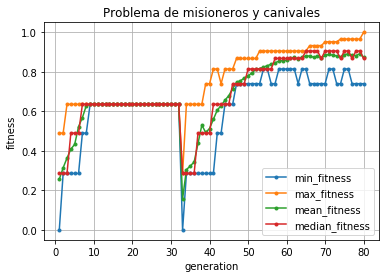

In [2]:
import sys
import random
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import deque, Sequence, Counter
from numbers import Integral
from enum import IntEnum, Enum, auto


class Group():
    """Group of misioneros and cannibals"""
    def __init__(self, misioneros, cannibals):
        self.reset(misioneros, cannibals)
    
    def reset(self, misioneros, cannibals):
        self.misioneros = misioneros
        self.cannibals = cannibals
    
    def __str__(self):
        return  f'(m:{self.misioneros}, c:{self.cannibals})'
    
    def __add__(self, other):
        assert isinstance(other, Group)
        return Group(self.misioneros + other.misioneros,
                     self.cannibals + other.cannibals)
    
    def __sub__(self, other):
        assert isinstance(other, Group)
        return Group(self.misioneros - other.misioneros,
                     self.cannibals - other.cannibals)
    
    def is_valid(self):
        return 0 <= self.misioneros <= 3 and 0 <= self.cannibals <= 3  
        '''Devolver 0 para cuando los misioneros sean 3 y los canivales 0'''
    
    def is_capacity_over(self):
        return not (1 <= (self.misioneros + self.cannibals) <= 2)
        '''No devuelve cuando los canovales son mayores a los misioneros'''
    
    def is_safe(self):
        return self.misioneros == 0 or self.misioneros >= self.cannibals
        '''Devuelve seguro cuando no hay misioneros cerca a mayor cantidad de canivales'''
    
    def is_empty(self):
        return self.misioneros == self.cannibals == 0
        '''Salvados cuando los misiones y canivales estan igualados a 0'''


class MCProblem():
    """Problema de micioneros y canivales"""
    _LEFT_BANK = 0
    # Mover el barco a la isquierda tiene el valor de 0
    _RIGHT_BANK = 1
    # Mover el barco a la derecha con un valor de 1
    class Result(Enum):
        ILLEGAL_MOVE = auto() # Movimiento invalido
        CAPACITY_OVER = auto() # Maxima capacidad en el bote
        EATEN_BY_CANNIBALS = auto() # Comido por canivales
        REPETITION = auto() # Repeticion
        LEGAL_MOVE = auto() # Movimineto Valido
        GAME_CLEAR = auto() # Limpiar Juego
    
    def __init__(self):
        self.searched_nodes = 0
        self.reset()
    
    def reset(self):
        self._left_bank = Group(3, 3) # En el costado isquierdo la canditadad de canivales y misioneros que hay 
        self._right_bank = Group(0, 0) # En el costado derecho la canditadad de canivales y misioneros que no hay 
        self._boat_position = self._LEFT_BANK # Pocision inicial del bote en el lado isquierdo
        self._records = [self._record()] # Contador de puntos de valor
    
    def _record(self):
        return hash((str(self._left_bank),
                     str(self._right_bank), self._boat_position))
    
    _boat = {_LEFT_BANK : '=  ', _RIGHT_BANK: '  ='} # Como se expresara los movimientos desde la isquierda a la derecha
    
    def __str__(self):
        boat = self._boat[self._boat_position] # Pocision inicial del bote
        left_bank = str(self._left_bank) # Bote del lado isuqierdo 
        right_bank = str(self._right_bank) # Bote del lado derecho
        return left_bank + boat + right_bank # Devolver la pocision del barco de isquierda, barco, derecha
    
    def _forward(self, passengers, verbose): # Desde la pocision inicial ISQUIERDA
        self._left_bank -= passengers # Pocision isquierda del bote menos los pasageros
        self._right_bank += passengers # Pocision de la dercha mas los pasageros
        self._boat_position = self._RIGHT_BANK # Devolver el bote a la derecha
        if verbose:
            print(f'    ==(m:{passengers.misioneros},' # Cantidad de misioneros que siguen en ese lado
                  f' c:{passengers.cannibals})=>') # Cantidad de canivales que siguen en ese lado
    
    def _backward(self, passengers, verbose): # NUEVA POCISION
        self._left_bank += passengers # Pocision de isquierda mas los pasajeros que van el bote
        self._right_bank -= passengers # Pocision de derecha con los pasajeros que llegan
        self._boat_position = self._LEFT_BANK # Devolver el bote hacia la isquierda
        if verbose:
            print(f'    <=(m:{passengers.misioneros},' # Cantidad de misioneros que llegaron al lado derecho
                  f' c:{passengers.cannibals})==') # Cantidad de canivales que llegan al lado derecho 
    
    _cross_the_river = {_LEFT_BANK : _forward, # CRUZAR EL LAGO
                        _RIGHT_BANK: _backward}
    
    def _move(self, passengers, verbose):
        self._cross_the_river[self._boat_position](self, passengers, verbose) # Cruce del rio con misioneros y canivales
        
        if not (self._left_bank.is_valid() and self._right_bank.is_valid()):
            return self.Result.ILLEGAL_MOVE # Resultado de movimiento invalido
        
        if passengers.is_capacity_over():
            return self.Result.CAPACITY_OVER # Capacidad de movimientos lleno
        
        if not (self._left_bank.is_safe() and self._right_bank.is_safe()):
            return self.Result.EATEN_BY_CANNIBALS # Movimiento invalido por que se comieron los canivales a misioneros
        
        if self._record() in self._records:
            return self.Result.REPETITION # Movimiento de repeticion para ver opcion o validacion
        
        if self._left_bank.is_empty():
            return self.Result.GAME_CLEAR # Limpiar juego
        
        self._records.append(self._record())
        return self.Result.LEGAL_MOVE # Movimiento Legal o valido para consultar fitnes
    
    _countup = {Result.ILLEGAL_MOVE: 0, Result.CAPACITY_OVER: 0,
                Result.EATEN_BY_CANNIBALS: 0, Result.REPETITION: 0,
                Result.LEGAL_MOVE: 1, Result.GAME_CLEAR: 1} # Resultados de los moviminetos para ser evaluados
    
    def moves(self, misioneros, cannibals, verbose=False): # MOVIMIENTOS
        assert len(misioneros) == len(cannibals) # TAMAÑO DE MISIONEROS  IAGUAL A CANIVALES
        self.reset() # LIMPIAR
        legal_moves = 0
        for i in range(len(misioneros)):
            '''consultar si no se comen entre el movimiento para evaluacion'''
            if verbose: print(self)
            result = self._move(Group(misioneros[i], cannibals[i]), verbose)
            self.searched_nodes += 1
            legal_moves += self._countup[result]
            if result == self.Result.LEGAL_MOVE:
                continue
            break
        if verbose: print(self)
        return result, legal_moves


class Individual():
    """Individuo que representa la respuesta al problema o que lo realizara"""
    _GENE_SIZE = 100 # Tamaño de los genes
    
    _MASK_UINT2 = 0b11 # Capas de utilizacion
    _SHIFT_UINT2 = 2 # Maximo cantidad en los genes
    
    _MUTATE_PROBABILITY = 0.05 # Probabilidad de mutacion
    
    def __init__(self, mc_problem, gene=None):
        if gene is None:
            self.gene = random.getrandbits(self._GENE_SIZE) # Aignacion randonica a los genes 
        else:
            assert 0 <= gene < 2 ** self._GENE_SIZE # No pasar a mayor de 2
            self.gene = gene # Asignar el nuevo gen
        self._mc_problem = mc_problem # TIPODE PROBLEMA DE MISIONEROS Y CANIVALES
        
        # analizar los primeros genes
        gene = self.gene
        
        self.misioneros = [0] * (self._GENE_SIZE // 4) 
        # Al gen de misioneros se loe valua por la multiplicacion del doble de una divicion por 4
        self.cannibals = [0] * (self._GENE_SIZE // 4)
        # Al gen del canival se loe valua por la multiplicacion del doble de una divicion por 4
        for i in range(self._GENE_SIZE // 4): # Recorremos el gen en la doble cuartaparte del tamaño de los genes
            self.misioneros[i] = (gene & self._MASK_UINT2) # Se ele asigna el gen con la evaluacion de Maximo de unidades
            gene = gene >> self._SHIFT_UINT2 # Genes toma el valor de gen para el tipo de unidad de maximo 2
        
        for i in range(self._GENE_SIZE // 4): # Recorremos el gen en la doble cuartaparte del tamaño de los genes
            self.cannibals[i] = (gene & self._MASK_UINT2) # Se ele asigna el gen con la evaluacion de Maximo de unidades
            gene = gene >> self._SHIFT_UINT2 # Genes toma el valor de gen para el tipo de unidad de maximo 2
        
        # Calculamos su fitnes
        self.calc_fitness()
    
    def _formula1(self):
        return 1. - (1. / 1.4 ** self.legal_moves)
    '''EVALUACION DE LOS GENES EN BASE A FIDONEIDAD PARA VER SI SON PARTE DEL PROBLEMA'''
    def _formula2(self):
        return 1.
    '''Se determina cual formula usaran segun su caracteristica del resultado de posibilidad a realizarce'''
    _fitness_from = {MCProblem.Result.ILLEGAL_MOVE      : _formula1,
                     MCProblem.Result.CAPACITY_OVER     : _formula1,
                     MCProblem.Result.EATEN_BY_CANNIBALS: _formula1,
                     MCProblem.Result.REPETITION        : _formula1,
                     MCProblem.Result.LEGAL_MOVE        : _formula1,
                     MCProblem.Result.GAME_CLEAR        : _formula2}
    
    def calc_fitness(self): # Calculamos la fidoneidad
        self.result, self.legal_moves = \
        self._mc_problem.moves(self.misioneros, self.cannibals)
        self.fitness = self._fitness_from[self.result](self)
    
    def _is_valid_operand(self, other):
        return hasattr(other, 'fitness')
    
    def __eq__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return self.fitness == other.fitness
    
    def __ne__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return self.fitness != other.fitness
    
    def __lt__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return self.fitness < other.fitness
    
    def __le__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return self.fitness <= other.fitness
    
    def __gt__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return self.fitness > other.fitness
    
    def __ge__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return self.fitness >= other.fitness
    
    def __str__(self):
        return f'gene: {self.gene}'
    
    def mate(self, other, mc_problem):
        """Nuevo hijo de los genes del padre"""
        assert isinstance(other, Individual)
        
        child_gene = 0 # Nodos hijos empiezan en 0
        self_gene = self.gene # Seleccion de los genes
        other_gene = other.gene # Otros genes
        
        # Herencia de los padres
        mask_mate = random.getrandbits(self._GENE_SIZE)
        self_gene = self_gene & mask_mate # Seleccion de genes y su limitante o parecido con los padres
        other_gene = other_gene & ~mask_mate # Otros genes con caracteristicas de los padres
        child_gene = self_gene | other_gene # Hijos de genes con otras genes a heredar
        
        # Mutacion de los genes
        mask_mutation = 0 # Tipo de mascara o cualidad para mutacion
        for _ in range(self._GENE_SIZE):
            mask_mutation = mask_mutation << 1
            if random.random() <= self._MUTATE_PROBABILITY:
                mask_mutation = mask_mutation | 0b1
        child_gene = child_gene ^ mask_mutation
        
        return Individual(mc_problem, child_gene)


class Poblacion():
    """Individuos"""
    _FERTILITY_RATE = 10 # TAZA DE CONVERGENCIA
    _CATASTOROPHE_DAMAGE = 100 # PROBABILIDAD DE DAÑO EN MUTACION
    
    def __init__(self, mc_problem, Poblacion_size):
        self._mc_problem = mc_problem
        self._Poblacion_size = Poblacion_size
        self.generation = [Individual(self._mc_problem)
                              for _ in range(self._Poblacion_size)]
        self.generation.sort(reverse=True)
        self.generation_number = 0
    
    def next_generation(self):
        self.generation_number += 1
        
        # Dividiar  a los individuos en grupos o no grupos
        pareto = self._Poblacion_size // 5
        elites = self.generation[: pareto]
        non_elites = self.generation[pareto :]
        
        # Todos los participantes tienen el chance de cambiar a equipos y no equipos
        children = []
        for parent1 in elites:
            parent2 = random.choice(non_elites)
            for _ in range(self._FERTILITY_RATE):
                children.append(parent1.mate(parent2, self._mc_problem))
        
        # Seleccion de Individuos para Sobrevivir
        elites = random.sample(elites, 12 * len(elites) // 15)
        non_elites = random.sample(non_elites, 3 * len(non_elites) // 15)
        self.generation = elites + children + non_elites
        self.generation.sort(reverse=True)
        self.generation = self.generation[: self._Poblacion_size]
        
        # Nueva Generacion
        min_fitness = self.generation[-1].fitness
        max_fitness = self.generation[0].fitness
        mean_fitness = mean(i.fitness for i in self.generation)
        median_fitness = self.generation[self._Poblacion_size // 2].fitness
        
        return Aspect(min_fitness, max_fitness, mean_fitness, median_fitness)
    
    def catastrophe(self):
        """Mutacion de genes"""
        survivor_num = self._Poblacion_size // self._CATASTOROPHE_DAMAGE
        survivor = random.sample(self.generation, survivor_num)
        newcomer = [Individual(self._mc_problem)
                        for _ in range(self._Poblacion_size)]
        self.generation = survivor + newcomer
        self.generation.sort(reverse=True)
        self.generation = self.generation[: self._Poblacion_size]


class Aspect():
    """aspectos de la mutacion"""
    def __init__(self, min, max, mean, median):
        self.min = min
        self.max = max
        self.mean = mean
        self.median = median


class Data4Graph():
    """Almacenamiento de los datos para dibujar un gráfico"""
    def __init__(self):
        self.min = []
        self.max = []
        self.mean = []
        self.median = []
    
    def append(self, aspect):
        assert isinstance(aspect, Aspect)
        self.min.append(aspect.min)
        self.max.append(aspect.max)
        self.mean.append(aspect.mean)
        self.median.append(aspect.median)
    
    def check(self):
        return (len(self.min)
                == len(self.max) == len(self.mean) == len(self.median))


def visualize(data4graph):
    """Dibujo y grafico"""
    assert isinstance(data4graph, Data4Graph)
    assert data4graph.check()
    x = range(1, len(data4graph.min) + 1)
    plt.figure()
    plt.plot(x, data4graph.min, marker='.', label='min_fitness')
    plt.plot(x, data4graph.max, marker='.', label='max_fitness')
    plt.plot(x, data4graph.mean, marker='.', label='mean_fitness')
    plt.plot(x, data4graph.median, marker='.', label='median_fitness')
    plt.legend(bbox_to_anchor=(1, 0), loc='lower right', fontsize=10)
    plt.grid()
    plt.xlabel('generation')
    plt.ylabel('fitness')
    plt.title('Problema de misioneros y canivales')
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    plt.show()


def is_ipython():
    try:
        get_ipython()
    except:
        result = False
    else:
        result = True
    return result


class OutputManager():
    """Gestion de salida"""
    def __init__(self, verbose):
        self._verbose = verbose
        self._ipython = is_ipython()
    
    _arrow = {0: '\r↑', 1: '\r→', 2: '\r↓', 3: '\r←'}
    
    def _clear_output(self):
        if self._ipython:
            # carriage return only
            s = '\r'
        else:
            # erase in line and carriage return
            s = '\033[2K\033[G'
        sys.stdout.write(s)
        sys.stdout.flush()
    
    def success(self, generation_number, aspect_max, legal_moves, # Sucesores de movimineto para revision de donde no caer
                searched_nodes, answer_gene, misioneros, cannibals):
        if self._verbose == 0:
            self._clear_output()
        print(f'{generation_number}: {aspect_max}({legal_moves})')
        print(f'Busqueda de Nodos: {searched_nodes}')
        print(answer_gene)
        print(f'm: {misioneros}')
        print(f'c: {cannibals}')
    
    def continue_(self, generation_number, aspect_max, legal_moves):
        if self._verbose == 0:
            if not self._ipython: self._clear_output()
            if self._ipython:
                s = self._arrow[generation_number % 4]
            else:
                s = f'{generation_number}: {aspect_max}({legal_moves})'
            sys.stdout.write(s)
            sys.stdout.flush()
        elif self._verbose > 0:
            print(f'{generation_number}: {aspect_max}({legal_moves})')
    
    def catastrophe(self): # EN caso de catastrofe para alarmar y nueva seleccion
        if self._verbose == 0:
            if self._ipython:
                s = '\r※'
            else:
                self._clear_output()
                s = 'Catastrofe ocurrida!'
            sys.stdout.write(s)
            sys.stdout.flush()
        elif self._verbose > 0:
            print('Catastrofe ocurrida!')
    
    def epoch_over(self, generation_number, aspect_max, legal_moves):
        if self._verbose == 0:
            self._clear_output()
            print(f'{generation_number}: {aspect_max}({legal_moves})')

#decodifica_mochila([1, 1, 0, 1], 4, [18, 2, 8, 1], 20)
# [1, 1, 0, 0]

# Definir función fitness
# fitness_mochila(cromosoma, n_objetos, pesos, capacidad, valores)
# devuelve el valor total de los objetos que están dentro de la mochila
# que representa el cromosoma, según la codificación explicada en el ejercicio
# anterior. Aquí valores es la lista de los valores de cada objeto y el resto
# de argumentos son los mismos que en el ejercicio anterior.
class EvolutionController():
    """Control de la evolucion"""
    def __init__(self, mc_problem, Poblacion_size=100, epochs=1000,
                 patience=30, verbose=0, graph=False):
        self._mc_problem = mc_problem
        self._Poblacion = Poblacion(self._mc_problem, Poblacion_size)
        self._epochs = epochs
        self._patience = patience 
        self._memory = deque([], patience)
        self._graph = graph
        if self._graph: self._data4graph = Data4Graph()
        self._outmgr = OutputManager(verbose)
    
    def start(self):
        """Empezar mutacion o evolucion"""
        for epoch in range(1, self._epochs + 1):
            aspect = self._Poblacion.next_generation()
            top1 = self._Poblacion.generation[0]
            if aspect.max == 1.:
                answer = (top1.misioneros[:top1.legal_moves],
                          top1.cannibals[:top1.legal_moves])
                self._outmgr.success(self._Poblacion.generation_number,
                                     aspect.max, top1.legal_moves,
                                     self._mc_problem.searched_nodes,
                                     str(top1), *answer)
                # Imrprimir la solucion
                self._mc_problem.reset()
                self._mc_problem.moves(*answer, verbose=True)
                
                if self._graph:
                    self._data4graph.append(aspect)
                    visualize(self._data4graph)
                break
            else:
                self._outmgr.continue_(self._Poblacion.generation_number,
                                       aspect.max, top1.legal_moves)
                if self._graph:
                    self._data4graph.append(aspect)
                
                # Revicion de catastrofe
                self._memory.append(aspect.max)
                if self._memory.count(self._memory[-1]) == self._patience:
                    self._outmgr.catastrophe()
                    self._Poblacion.catastrophe()
        else:
            self._outmgr.epoch_over(self._Poblacion.generation_number,
                                    aspect.max,
                                    self._Poblacion.generation[0].legal_moves)
            if self._graph:
                visualize(self._data4graph)


def moves_for_0th_gen(n=10):
    mc_problem = MCProblem()
    xs = [Individual(mc_problem) for _ in range(n)]
    for x in xs:
        result, _ = mc_problem.moves(x.misioneros, x.cannibals, verbose=True)
        print(result)
        print(f'------------------')


def stat_for_0th_gen(n=100):
    mc_problem = MCProblem()
    xs = [Individual(mc_problem) for _ in range(n)]
    legal_moves = Counter([x.legal_moves for x in xs])
    results = Counter([x.result for x in xs])
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_title('Movimientos Legales')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.pie(legal_moves.values(), labels=legal_moves.keys(),
            autopct='%.1f', pctdistance=0.6, labeldistance=1.1,
            startangle=90, frame=False)
    ax1.axis('Igual')
    if not is_ipython(): fig1.show()
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_title('Resultado')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.pie(results.values(), labels=results.keys(),
            autopct='%.1f', pctdistance=0.6, labeldistance=1.1,
            startangle=90, frame=False)
    ax2.axis('Igual')
    if not is_ipython(): fig2.show()


def main():
    mc_problem = MCProblem()
    ec = EvolutionController(mc_problem, verbose=0, graph=True)
    ec.start()


if __name__ == '__main__':
    main()